This notebook generates plots of the "pseudorandom" trajectories used in the 02.14.2021 version of the eye-movement classification model training data collection task (EMC).

In [1]:
!git clone http://github.com/megawattfs/schrayer-msai-research

Cloning into 'schrayer-msai-research'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 97 (delta 6), reused 29 (delta 6), pack-reused 67
Unpacking objects: 100% (97/97), done.
Checking out files: 100% (18/18), done.


In [2]:
!ls

sample_data  schrayer-msai-research


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
!ls schrayer-msai-research/

deborah_test_2_18-1.csv		   out_and_back_2_15.csv
deborah_test_2_18-2.csv		   plot_pseudorandom_trajectories.csv
EMC_gaze.dlm			   plot_pseudorandom_trajectories.ipynb
EMC_gaze.slx			   README.md
EMC_no_gaze.dlm			   test_diag.csv
EMC_no_gaze.slx			   test_pseudo.csv
EMC_no_hand.dlm			   test_sine.csv
EMC_no_hand.slx			   test_vert.csv
eye_movement_classification.ipynb  transformed_pseudorandoms.csv


In [4]:
exam_data_1 = pd.read_csv("schrayer-msai-research/deborah_test_2_18-1.csv",skiprows=261)
exam_data_2 = pd.read_csv("schrayer-msai-research/deborah_test_2_18-2.csv",skiprows=0,header=None)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,6,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
exam_data = pd.DataFrame(np.concatenate((exam_data_1.values, exam_data_2.values),axis=0))
exam_data.columns = exam_data_1.columns

In [6]:
exam_data.head()

,Trial #,TP Row,Block Row,Sample duration (s),Sample count,Event name,Event time (s),Video frame sent,Video frame ACKed,Frame #,Frame time (s),Right_L1Ang,Right_L2Ang,Right_L1Vel,Right_L2Vel,Right_L1Acc,Right_L2Acc,Right_M1TorCMD,Right_M2TorCMD,Right_FS_ForceX,Right_FS_ForceY,Right_FS_ForceZ,Right_FS_TorqueX,Right_FS_TorqueY,Right_FS_TorqueZ,Right_FS_TimeStamp,Right_FS_Status,Left_L1Ang,Left_L2Ang,Left_L1Vel,Left_L2Vel,Left_L1Acc,Left_L2Acc,Left_M1TorCMD,Left_M2TorCMD,Left_FS_ForceX,Left_FS_ForceY,Left_FS_ForceZ,Left_FS_TorqueX,Left_FS_TorqueY,Left_FS_TorqueZ,Left_FS_TimeStamp,Left_FS_Status,Gaze_X,Gaze_Y,Gaze_TimeStamp,Gaze_PupilArea,Gaze_Vector_X,Gaze_Vector_Y,Gaze_Vector_Z,Gaze_Pupil_X,Gaze_Pupil_Y,Gaze_Pupil_Z,StatusBits,target_on,target_x,target_y,head_x,head_y,head_z,Right: Hand position X,Right: Hand position Y,Right: Hand speed,Right: Hand velocity X,Right: Hand velocity Y,Right: Hand acceleration,Right: Hand acceleration X,Right: Hand acceleration Y,Right: Hand cmd force X,Right: Hand cmd force Y,Right: Hand cmd force,Left: Hand position X,Left: Hand position Y,Video frame interval time,Video frame drop count
0,1,1,6,0.001,10635,NaN,NaN,NaN,NaN,0,0,-0.660198,-2.46371,0,0,0,0,0,0,-0.0163251,0.00657687,-0.03196,-0.000691588,0.000540766,5.7e-05,2.17514,0,0.0705679,-0.0705679,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00725702,0.240271,2.176,2.13716e-05,-0.157447,0.697156,-0.699417,0.0876168,-0.115552,0.356977,0,0,0,0.2,0.0615182,-0.099716,0.374673,0.00432364,0.234556,0,0,0,0,0,0,0,0,0,0.194052,-0.208315,17,0
1,NaN,NaN,NaN,NaN,NaN,Trial Start,0.001,NaN,NaN,1,0.001,-0.660198,-2.46371,0,0,0,0,0,0,-0.0165747,0.00695072,-0.100762,-0.000660456,0.000332016,0.000365,2.17571,0,0.0705679,-0.0705679,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00725702,0.240271,2.176,2.13716e-05,-0.157447,0.697156,-0.699417,0.0876168,-0.115552,0.356977,0,1,0,0.2,0.0615182,-0.099716,0.374673,0.00432364,0.234556,0,0,0,0,0,0,0,0,0,0.194052,-0.208315,17,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0.002,-0.660198,-2.46371,0,0,0,0,0,0,-0.00995737,0.0124748,-0.112941,-0.000479367,0.000194946,0.000467,2.17686,0,0.0705679,-0.0705679,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00731636,0.240364,2.178,2.14188e-05,-0.157314,0.697259,-0.699344,0.0876168,-0.11555,0.356979,0,1,0,0.2,0.0615182,-0.099716,0.374673,0.00432364,0.234556,0,0,0,0,0,0,0,0,0,0.194052,-0.208315,17,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0.003,-0.660198,-2.46371,0,0,0,0,0,0,-0.0107415,0.0166269,-0.093832,-0.000274012,-8.2034e-05,0.000411,2.178,0,0.0705679,-0.0705679,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00731636,0.240364,2.178,2.14188e-05,-0.157314,0.697259,-0.699344,0.0876168,-0.11555,0.356979,0,1,0,0.2,0.0615182,-0.099716,0.374673,0.00432364,0.234556,0,0,0,0,0,0,0,0,0,0.194052,-0.208315,17,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0.004,-0.660198,-2.46371,0,0,0,0,0,0,0.00094447,0.0160708,-0.036629,-3.60699e-05,-0.000289422,-0.000112,2.17914,0,0.0705679,-0.0705679,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00735062,0.240363,2.18,2.14656e-05,-0.157249,0.697265,-0.699353,0.0876168,-0.11555,0.356979,0,1,0,0.2,0.0615182,-0.099716,0.374673,0.00432364,0.234556,0,0,0,0,0,0,0,0,0,0.194052,-0.208315,17,0


In [7]:
trajectory_data = exam_data[['Trial #','Frame time (s)','target_x','target_y','Gaze_X','Gaze_Y','Gaze_TimeStamp',
                            'Gaze_Vector_X','Gaze_Vector_Y','Gaze_Vector_Z','head_x','head_y','head_z','Right: Hand position X',
                            'Right: Hand position Y','Right: Hand cmd force X','Right: Hand cmd force Y']]

Reformat columns to floats

In [8]:
def sci_to_float(sci_string_arr):
  out_arr = np.zeros(sci_string_arr.size)
  for i in range(sci_string_arr.size):
    #Convert the string in scientific notation to a floating-point number
    sci_string = str(sci_string_arr[i])
    e_ind = sci_string.find('e')
    if e_ind == -1:#regular numeric conversion
      try:
        conv_float = float(sci_string)
      except ValueError:
        conv_float = float('NaN')
    else:
      try:
        base = float(sci_string[:e_ind])
        sign = sci_string[e_ind + 1]
        exp = int(sci_string[e_ind + 2:])
        if sign == '-':#Negative exponent
          conv_float = base * (10 ** (-1 * exp))
        else:#Positive exponent
          conv_float = base * (10 ** exp)
      except ValueError:
        conv_float = float('NaN')
    out_arr[i] = conv_float
  return out_arr

In [9]:
for col in trajectory_data.columns:
  trajectory_data[col] = pd.Series(sci_to_float(np.array(trajectory_data[col])))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
trajectory_data.dropna(how='all',inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
trajectory_data.head()

,Trial #,Frame time (s),target_x,target_y,Gaze_X,Gaze_Y,Gaze_TimeStamp,Gaze_Vector_X,Gaze_Vector_Y,Gaze_Vector_Z,head_x,head_y,head_z,Right: Hand position X,Right: Hand position Y,Right: Hand cmd force X,Right: Hand cmd force Y
209214,NaN,12.874,-0.0003,0.2,0.055614,0.235375,211.561996,-0.065433,0.698124,-0.712980,0.062012,-0.101074,0.376592,-0.000679,0.199107,0.0,0.0
209215,NaN,12.875,-0.0002,0.2,0.055614,0.235375,211.561996,-0.065433,0.698124,-0.712980,0.062012,-0.101074,0.376592,-0.000679,0.199107,0.0,0.0
209216,NaN,12.876,-0.0001,0.2,0.055572,0.234732,211.563995,-0.065574,0.697473,-0.713605,0.062012,-0.101074,0.376592,-0.000679,0.199107,0.0,0.0
209217,NaN,12.877,0.0000,0.2,0.055572,0.234732,211.563995,-0.065574,0.697473,-0.713605,0.062012,-0.101074,0.376592,-0.000679,0.199107,0.0,0.0
209218,NaN,12.878,0.0000,0.2,0.047756,0.234863,211.565994,-0.080806,0.696822,-0.712678,0.062012,-0.101074,0.376592,-0.000679,0.199107,0.0,0.0


In [12]:
#Pull the gaze data
gaze_data = trajectory_data[["Trial #","Gaze_TimeStamp","Gaze_X","Gaze_Y","Gaze_Vector_X","Gaze_Vector_Y","Gaze_Vector_Z"]]

In [13]:
gaze_data.head()

,Trial #,Gaze_TimeStamp,Gaze_X,Gaze_Y,Gaze_Vector_X,Gaze_Vector_Y,Gaze_Vector_Z
0,1.0,2.176,0.007257,0.240271,-0.157447,0.697156,-0.699417
1,NaN,2.176,0.007257,0.240271,-0.157447,0.697156,-0.699417
2,NaN,2.178,0.007316,0.240364,-0.157314,0.697259,-0.699344
3,NaN,2.178,0.007316,0.240364,-0.157314,0.697259,-0.699344
4,NaN,2.180,0.007351,0.240363,-0.157249,0.697265,-0.699353


Split trajectory data into individual trials

In [14]:
def split_trajectory_data(traj_df):
  trial_df_list = []
  trial_split_indices = [0]
  trial_num_ser = traj_df['Trial #']
  current_trial_num = 2
  current_trial_index = -1
  
  #Find all the split indices
  while current_trial_index != 0:
    current_trial_index = (trial_num_ser==current_trial_num).argmax()
    trial_split_indices.append(current_trial_index)
    current_trial_num += 1
  print("Num trials: " + str(current_trial_num - 2))
  trial_split_indices = trial_split_indices[:-1]#Removes the extra 0
  print(trial_split_indices)

  for i in range(len(trial_split_indices) - 1):
    sub_df = traj_df.iloc[trial_split_indices[i]:trial_split_indices[i+1],:]
    trial_df_list.append(sub_df)
  #Last one
  sub_df = traj_df.iloc[trial_split_indices[len(trial_split_indices) - 1]:-1,:]
  trial_df_list.append(sub_df)

  return trial_df_list

In [15]:
split_trials = split_trajectory_data(trajectory_data)
for trial in split_trials:
  trial.reset_index(inplace=True,drop=True)


Num trials: 21
[0, 10635, 19074, 27409, 35511, 43810, 51918, 60201, 69979, 78119, 86318, 94022, 101726, 109881, 117585, 125390, 133094, 158906, 180106, 188052, 196040]


In [16]:
traj1 = split_trials[10]
traj1.head()

,Trial #,Frame time (s),target_x,target_y,Gaze_X,Gaze_Y,Gaze_TimeStamp,Gaze_Vector_X,Gaze_Vector_Y,Gaze_Vector_Z,head_x,head_y,head_z,Right: Hand position X,Right: Hand position Y,Right: Hand cmd force X,Right: Hand cmd force Y
0,11.0,0.000,0.0,0.2,NaN,NaN,88.688004,100.0,100.0,100.0,-100.0,-100.0,-100.0,0.004246,0.198868,0.0,0.0
1,NaN,0.001,0.0,0.2,NaN,NaN,88.690002,100.0,100.0,100.0,-100.0,-100.0,-100.0,0.004246,0.198868,0.0,0.0
2,NaN,0.002,0.0,0.2,NaN,NaN,88.690002,100.0,100.0,100.0,-100.0,-100.0,-100.0,0.004246,0.198868,0.0,0.0
3,NaN,0.003,0.0,0.2,NaN,NaN,88.692001,100.0,100.0,100.0,-100.0,-100.0,-100.0,0.004246,0.198868,0.0,0.0
4,NaN,0.004,0.0,0.2,NaN,NaN,88.692001,100.0,100.0,100.0,-100.0,-100.0,-100.0,0.004247,0.198869,0.0,0.0


In [17]:
def plot_traj(traj1):
  plt.gca().set_aspect('equal', adjustable='box')
  plt.plot(traj1['target_x'],traj1['target_y'])
  plt.plot(traj1['target_x'][0],traj1['target_y'][0],'r+')
def plot_gaze(traj1):
  plt.gca().set_aspect('equal', adjustable='box')
  plt.plot(traj1['Gaze_X'],traj1['Gaze_Y'])
  plt.plot(traj1['Gaze_X'][0],traj1['Gaze_Y'][0],'r+')
def plot_gaze_vector_x(traj1):
  plt.gca().set_aspect('equal', adjustable='box')
  plt.plot(traj1['Gaze_TimeStamp'],traj1['Gaze_Vector_X'])
  plt.plot(traj1['Gaze_TimeStamp'][0],traj1['Gaze_Vector_X'][0],'r+')
def plot_gaze_vector_y(traj1):
  plt.gca().set_aspect('equal', adjustable='box')
  plt.plot(traj1['Gaze_TimeStamp'],traj1['Gaze_Vector_Y'])
  plt.plot(traj1['Gaze_TimeStamp'][0],traj1['Gaze_Vector_Y'][0],'r+')
def plot_gaze_vector_z(traj1):
  plt.gca().set_aspect('equal', adjustable='box')
  plt.plot(traj1['Gaze_TimeStamp'],traj1['Gaze_Vector_Z'])
  plt.plot(traj1['Gaze_TimeStamp'][0],traj1['Gaze_Vector_Z'][0],'r+')
def plot_head(traj1):
  plt.plot(traj1['Frame time (s)'],traj1['head_z'])

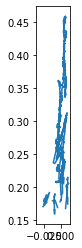

In [18]:
plot_gaze(traj1)

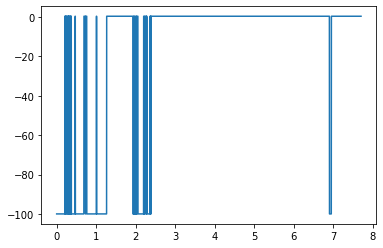

In [ ]:
plot_head(traj1)

In [20]:
split_gaze_trials = split_trajectory_data(gaze_data)

Num trials: 21
[0, 10635, 19074, 27409, 35511, 43810, 51918, 60201, 69979, 78119, 86318, 94022, 101726, 109881, 117585, 125390, 133094, 158906, 180106, 188052, 196040]


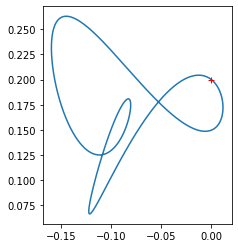

In [22]:
traj1 = split_trials[0]
plot_traj(traj1)

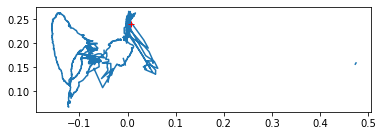

In [21]:
trial1 = split_gaze_trials[0]
plot_gaze(trial1)

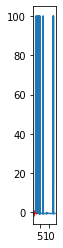

In [30]:
plot_gaze_vector_z(trial1)